In [13]:
import pandas as pd, numpy as np, os, sqlite3 as db3
from matplotlib import pyplot as plt
import missingno as msno # for displaying NAs graphically
from py.tobit import *

Let's specify an output folder:

In [4]:
direc = os.getcwd()
data_dir = os.path.join(direc,'CleanedData')

## Electricity Demand

Get demand:

In [6]:
df_demand = pd.read_pickle(os.path.join(data_dir,'Load_IE_2008_2022'))

### Missing values in forcasted loads and actual loads

In [11]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131496 entries, 0 to 131495
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype                        
---  ------              --------------   -----                        
 0   g_E                 131496 non-null  object                       
 1   HourUTC             131496 non-null  datetime64[ns, Europe/Dublin]
 2   Month               131496 non-null  int64                        
 3   Week                131496 non-null  UInt32                       
 4   Weekday             131496 non-null  int64                        
 5   HourOfTheDay        131496 non-null  int64                        
 6   h                   131496 non-null  int64                        
 7   ForecastedLoad_MWh  65712 non-null   float64                      
 8   ActualLoad_MWh      64784 non-null   float64                      
dtypes: UInt32(1), datetime64[ns, Europe/Dublin](1), float64(2), int64(4), object(1)
memory usage:

<Axes: >

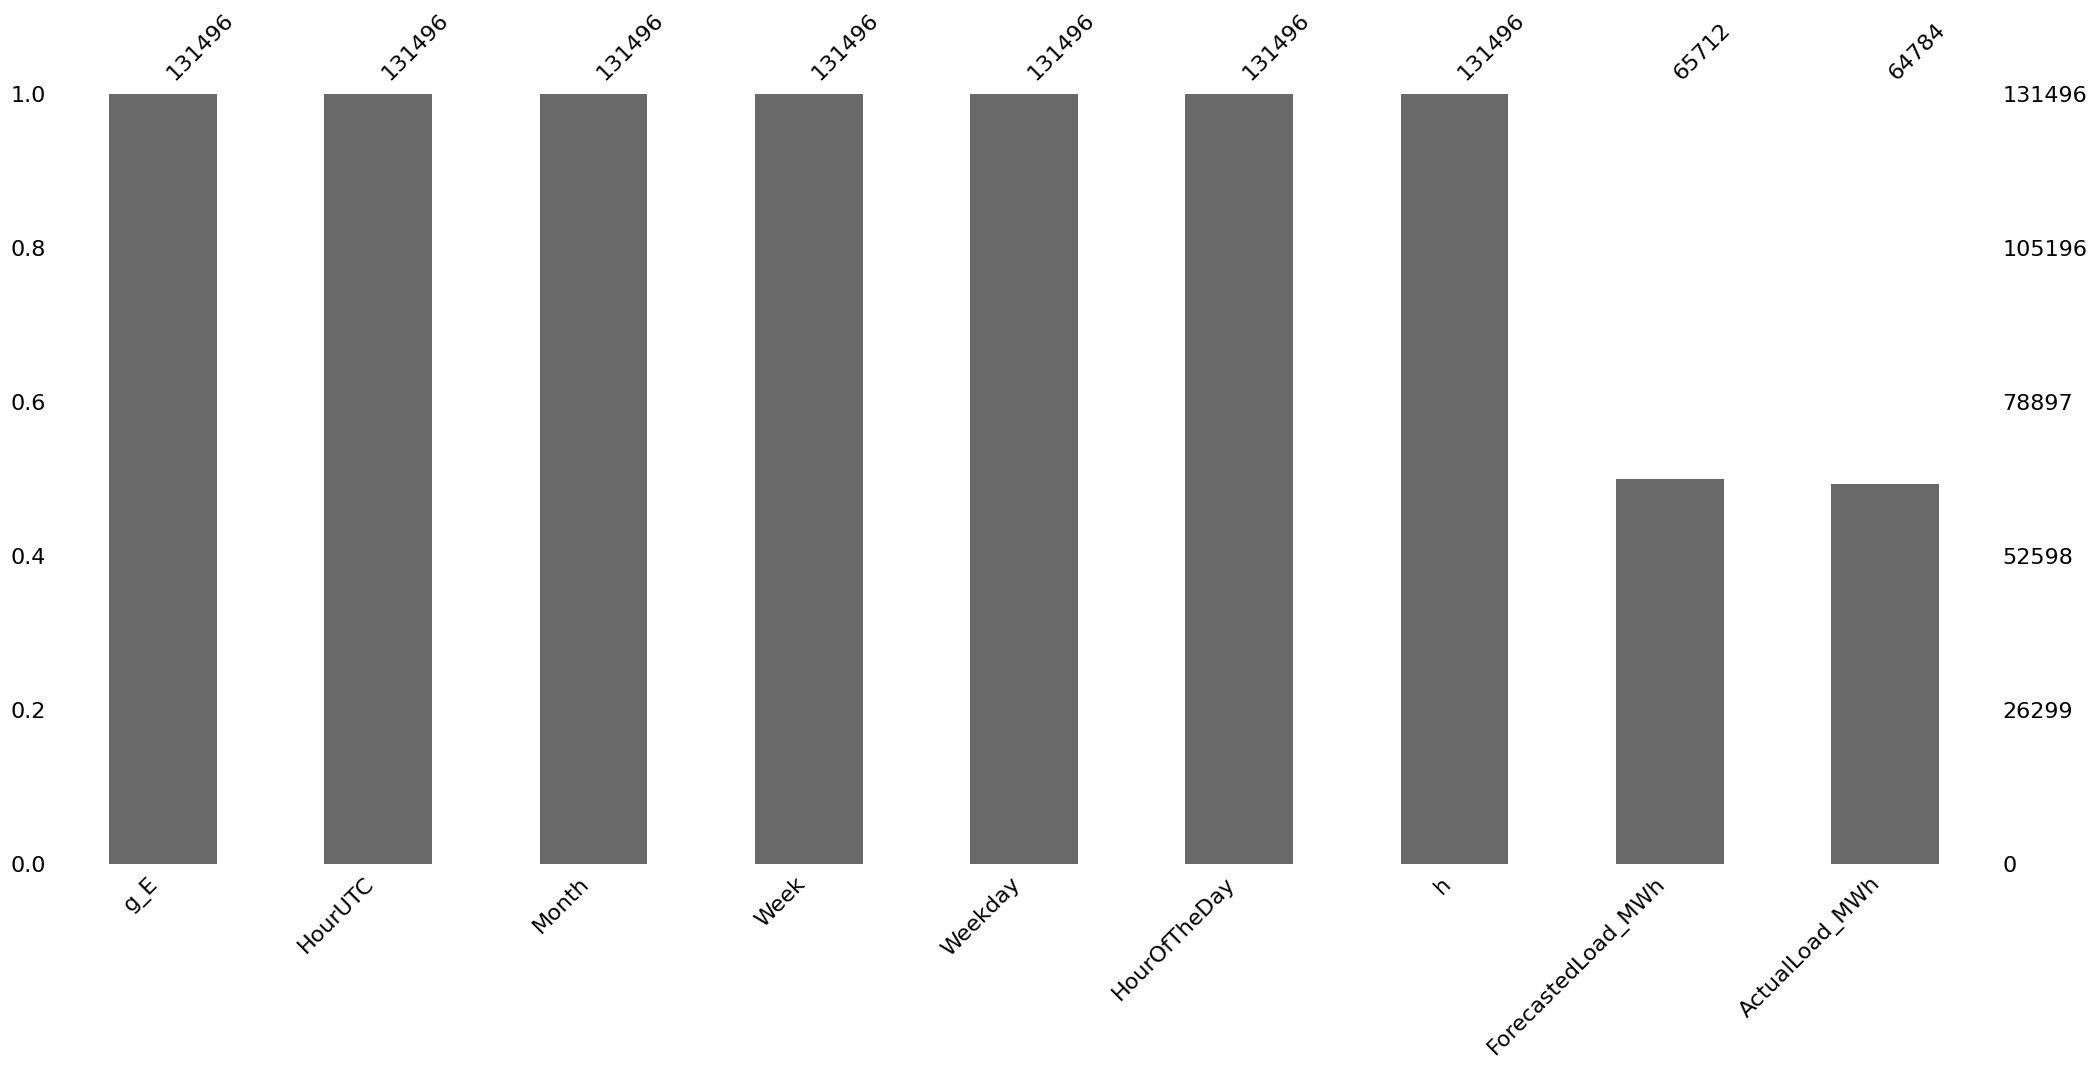

In [14]:
msno.bar(df_demand)

From the above illustrations we see that $\frac{131'496-65'712}{131'496} \cdot 100 = 50.03 \%$ of values of *ForecastedLoad_MWh* and $\frac{131'496-64'784}{131'496} \cdot 100 = 50.73 \%$ of values of *ActualLoad_MWh* are missing. We have to keep this as a limitation in mind when analysing the model outcomes.

Get areas:

In [15]:
g_area = df_demand['g_E'].unique().tolist()

In [16]:
print(g_area)

['IE']


Estimate hourly variation in demand:

In [17]:
# Make X and y variables:
xvar, yvar = ['intercept','ForecastedLoad_MWh'], 'ActualLoad_MWh'
d_yhat = {}
for g in g_area:
    idx_g = df_demand['g_E']==g
    df_tmp = df_demand[idx_g].copy()
    idx = df_tmp[xvar[1:]+[yvar]].isna().any(axis=1)
    X, y = df_tmp.assign(intercept=1.0).loc[~idx,xvar].values,df_tmp.loc[~idx,[yvar]].values
    # Make OLS estimator:
    β_hat = np.matmul(np.linalg.inv(np.matmul(np.transpose(X),X)),np.matmul(np.transpose(X),y))
    # Make predicted load given β_hat
    d_yhat[g] = pd.Series(np.matmul(df_tmp.assign(intercept=1.0)[xvar].values,β_hat).flatten(),index=pd.MultiIndex.from_product([['_'.join(['c',g])],df_tmp['h'].tolist()],names=['c_E','h']),name='LoadVariation_E')

y_hat = pd.concat([d_yhat[g] for g in d_yhat.keys()],axis=0)

In [19]:
y_hat.info()

<class 'pandas.core.series.Series'>
MultiIndex: 131496 entries, ('c_IE', 1) to ('c_IE', 131496)
Series name: LoadVariation_E
Non-Null Count  Dtype  
--------------  -----  
65712 non-null  float64
dtypes: float64(1)
memory usage: 6.7+ MB


In [20]:
# Count missing values
y_hat.isnull().sum()

65784

We see that the estimated hourly variation in demand (as expected) also has $\frac{131'496-65'784}{131'496} \cdot 100 = 49.97 \%$ of missing values.

Now calculate total yearly demand and share of hourly demand:

In [21]:
Load_E = y_hat.groupby('c_E').sum().rename('Load_E')
LoadVariation_E = y_hat.div(Load_E).rename('LoadVariation_E')

Download marginal prices:

In [7]:
df_prices = pd.read_pickle(os.path.join(data_dir,'SpotPrices_DELUDK1DK2NLNO2SE3SE4_2022'))

Drop DK prices:

In [8]:
df_prices = df_prices[df_prices['g_E'].str.find('DK')==-1]

We need to map the countries to the correct areas; we therefore download mappings of interconnectors:

In [9]:
df_ic = pd.read_pickle(os.path.join(data_dir,'TransmissionCapacities_DK_2022'))[['g_E','g_EE']].drop_duplicates()

Drop DK areas:

In [10]:
idx_DK = (df_ic['g_E'].str.find('DK')!=-1) & (df_ic['g_EE'].str.find('DK')!=-1)
df_ic = df_ic[~idx_DK].rename(columns={'g_E':'g_EE','g_EE':'g_E'})

Add the interconnectors to the prices:

In [11]:
df_prices = df_prices.merge(df_ic,how='outer')

Unstack:

In [12]:
# df_prices = df_prices.set_index(['h','g_E'])['SpotPrice_€/MWh'].unstack('g_E').rename_axis(None,axis=1)

Make marginal willingness to pay:

In [13]:
# Remove DK to DK connections:
idx = (df_prices['g_E'].str.find('DK')!=-1) & (df_prices['g_EE'].str.find('DK')!=-1)
MWP_E = df_prices[~idx].replace({'g_E':{x:'c_'+x for x in df_prices['g_E']}})

# Make labels:
MWP_E['c_E'] = [g_EE+'_ExportTo_'+g_E for g_EE,g_E in zip(MWP_E['g_EE'],MWP_E['g_E'].str.replace('c_',''))]
MWP_E = MWP_E.set_index(['c_E','h'])['SpotPrice_€/MWh'].rename('MWP_E').unstack('c_E').rename_axis(None,axis=1)

Add for domestic consumer:

In [14]:
c_E_doms = [''.join(['c_',g_EE]) for g_EE in df_prices['g_EE'].unique()]
MWP_E[c_E_doms] = 1000

## Supply variation

Get supply:

In [15]:
df_supply = pd.read_pickle(os.path.join(data_dir,'IntermittentSupply_DK1DK2_2022')).replace({'hvt':{'Solar':'PV','WindOffshore':'WS','WindOnshore':'WL'}})

Estimate hourly variation in supply:

In [16]:
d_y = {}
xvar, yvar = ['intercept','Forecast_MWh'], 'Actual_MWh'
nan_idx = df_supply[xvar[1:]+[yvar]].isna().any(axis=1)
g2hvt = df_supply[['g_E','hvt']].drop_duplicates()
g2hvt['label'] = ['_'.join([hvt,str(y)]) if g2hvt.groupby('hvt').size()[hvt]>1 else hvt for hvt,y in zip(g2hvt['hvt'],g2hvt['g_E'])]
for g,hvt,hvt_label in g2hvt.itertuples(index=False):
    # Subset data
    ghvt_idx = (df_supply['hvt']==hvt) & (df_supply['g_E']==g)
    mi = pd.Index(df_supply.loc[ghvt_idx,'h'].tolist(),name='h')
    idx = (~nan_idx) & (ghvt_idx) 
    df_tmp = df_supply[idx]
    if len(df_tmp)>0:
        X, y = df_tmp.assign(intercept=1.0)[xvar].values,df_tmp[[yvar]].values
        # Make OLS estimator:
        β_hat = np.matmul(np.linalg.inv(np.matmul(np.transpose(X),X)),np.matmul(np.transpose(X),y))
        # Make explanatory variables
        X_idx = df_supply.loc[ghvt_idx,xvar[-1]].isna()
        if X_idx.sum()>0:
            # Estimate missing values using 12 representative days:
            X_sim = df_supply[ghvt_idx][[xvar[-1]]+['HourOfTheDay','Month']]
            X_sim['dummy'] = X_sim.groupby(['HourOfTheDay','Month']).grouper.group_info[0]
            X_X = pd.get_dummies(X_sim.loc[~X_idx,'dummy'],drop_first=True).values
            y_X = X_sim.loc[~X_idx,[xvar[-1]]].values
            β_X = np.matmul(np.linalg.inv(np.matmul(np.transpose(X_X),X_X)),np.matmul(np.transpose(X_X),y_X))
            X_hat = np.matmul(pd.get_dummies(X_sim['dummy'],drop_first=True).values,β_X).flatten()
            X_sim.loc[X_idx,xvar[-1]] = X_hat[X_idx]
            X_sim = X_sim.assign(intercept=1.0)[xvar].values
        else:
            X_sim = df_supply[ghvt_idx].assign(intercept=1.0)[xvar].values
        # Make predicted load given β_hat
        d_y['_'.join([g,hvt])] = pd.Series(np.matmul(X_sim,β_hat).flatten(),index=mi,name=hvt_label)
    else:
        y_idx =  df_supply.loc[ghvt_idx,yvar].isna()
        if y_idx.sum()>0:
            # Estimate missing values using 12 representative days:
            y_sim = df_supply[ghvt_idx][[yvar]+['HourOfTheDay','Month']]
            y_sim['dummy'] = y_sim.groupby(['HourOfTheDay','Month']).grouper.group_info[0]
            X_y = pd.get_dummies(y_sim.loc[~y_idx,'dummy'],drop_first=True).values
            y_y = y_sim.loc[~y_idx,[yvar]].values
            β_y = np.matmul(np.linalg.inv(np.matmul(np.transpose(X_y),X_y)),np.matmul(np.transpose(X_y),y_y))
            y_hat = np.matmul(pd.get_dummies(y_sim['dummy'],drop_first=True).values,β_y).flatten()
            y_sim.loc[y_idx,yvar] = y_hat[y_idx]
            y_sim = y_sim.assign(intercept=1.0)[yvar].values
        else:
            y_sim = df_supply.loc[ghvt_idx,yvar].tolist()
        d_y['_'.join([g,hvt])] = pd.Series(y_sim,index=mi,name=hvt_label)

    # Collect in dataframe
CapVariation = pd.concat([d_y[hvt] for hvt in d_y.keys()],axis=1)

Get capacities:

In [17]:
df_plant = pd.read_pickle(os.path.join(data_dir,'PlantData_DK_2022'))
df_int = df_plant.loc[df_plant['tech'].isin(['PV','SH','WL','WS','ROR']),['id','g_E','g_H','tech','GeneratingCapacity_E','GeneratingCapacity_H','Generation_E','Generation_H']].rename(columns={'tech':'hvt'})

Make unique hvt identifier:

In [18]:
df_int['hvt'] = pd.Series(['_'.join([hvt,g_E]) if (str(g_H)=='nan') & (df_int.groupby('hvt').size()[hvt]>1) else '_'.join([hvt,str(g_H)]) if (isinstance(g_H,str)) & (df_int.groupby('hvt').size()[hvt]>1) else hvt for hvt,g_E,g_H in zip(df_int['hvt'],df_int['g_E'],df_int['g_H'])],index=df_int.index)

Compute capacity factors:

In [19]:
for hvt in CapVariation.columns:
    CapVariation[hvt] = CapVariation[hvt]/df_int.loc[df_int['hvt']==hvt,'GeneratingCapacity_E'].sum()

Assume solar heat has the same pattern as PV:

In [20]:
SH_gen = df_int[df_int['hvt'].str.find('SH')!=-1].set_index(['hvt'])['Generation_H']
SH_gen.index = pd.MultiIndex.from_tuples([('_'.join(hvt.replace('SH','PV').split('_')[0:2]),hvt) for hvt in SH_gen.index],name=['hvt_E','hvt'])
PV_gen = CapVariation[[x for x in CapVariation.columns if x.find('PV')!=-1]].sum().rename_axis('hvt_E')
scale = SH_gen.div(PV_gen)
for i in range(len(scale)):
    hvt_E, hvt = scale.index[i]
    CapVariation[hvt] = CapVariation[hvt_E]*scale[:,hvt].iloc[0]

Add standard:

In [21]:
CapVariation['Standard'] = 1

Save id2hvt mapping:

In [22]:
id2hvt = pd.concat([
    df_int[['id','hvt']],
    df_plant.loc[~df_plant['id'].isin(df_int['id']),['id']].assign(hvt='Standard')
],axis=0).reset_index(drop=True)

## Heat Demand

Download from Open Power System Data:

In [23]:
file_path = os.path.join(direc,'RawData','when2heat.csv')
if os.path.isfile(file_path):
    df_hd = pd.read_csv(file_path, sep=';', on_bad_lines='warn',decimal=',')
else:
    url = 'https://data.open-power-system-data.org/when2heat/2023-07-27/when2heat.csv'
    df_hd = pd.read_csv(url, sep=';', on_bad_lines='warn',decimal=',')
    df_hd.to_csv(file_path)

Subset to IE

In [24]:
IE_cols = ['utc_timestamp'] + [x for x in df_hd.columns if x.find('IE_')!=-1]
df_hd = df_hd[IE_cols].copy()

Format timestamp:

In [25]:
df_hd['HourUTC'] = pd.to_datetime(df_hd['utc_timestamp'].str.replace('T',' '),utc=True)
df_hd['HourCET/CEST'] = df_hd['HourUTC'].dt.tz_convert('Europe/Brussels')

(Subset year:)

In [26]:
#df_hd = df_hd[df_hd['HourCET/CEST'].dt.year==2022].drop(columns='utc_timestamp')

Now select the columns we need:

In [27]:
LoadVariation_H = df_hd.set_index(['HourCET/CEST'])[[x for x in df_hd.columns if x.find('heat_profile')!=-1]].sum(axis=1).rename('LoadVariation_H')

Linearly interpolate missing values:

In [28]:
LoadVariation_H = LoadVariation_H.reindex(pd.date_range(LoadVariation_H.index[0],LoadVariation_H.index[-1],freq='H'))
id_time = LoadVariation_H[LoadVariation_H.isna()].index
LoadVariation_H = LoadVariation_H.interpolate()

Add index:

- 2007: 1h
- 2008-2022: 15 years -> 131'400h
- "+" 1h (as we start at 1)
- = 131'402h

In [29]:
LoadVariation_H.index = pd.Index(range(1,131402),name='h')

Rescale load variation:

In [30]:
Tot_H = LoadVariation_H.sum()
LoadVariation_H = LoadVariation_H/Tot_H

Duplicate for all g_H areas:

In [31]:
mi = pd.MultiIndex.from_product([['c_'+x for x in df_plant['g_H'].dropna().unique()],LoadVariation_H.index],names=['c_H','h'])
LoadVariation_H = pd.Series(0,index=mi,name='LoadVariation_H').add(LoadVariation_H)

Get total demand:

In [32]:
Load_H = df_plant.groupby('g_H')['Generation_H'].sum().mul(10**6).rename('Load_H').rename_axis('c_H')
Load_H.index = ['c_'+x for x in Load_H.index]

## Transmission capacities 

Get hourly variations:

In [33]:
file_path = os.path.join(data_dir,'TransmissionCapacities_DK_2022')
df_ntc = pd.read_pickle(file_path)

Melt dataframe:

In [34]:
idx = (df_ntc['g_E']=='DK2') & (df_ntc['g_EE']=='DK1')
df_ntc = pd.concat([
    df_ntc.loc[~idx,['g_E','g_EE','h','ImportCapacity_MW']].rename(columns={'g_E':'g_EE','g_EE':'g_E','ImportCapacity_MW':'NTC'}),
    df_ntc.loc[~idx,['g_E','g_EE','h','ExportCapacity_MW']].rename(columns={'ExportCapacity_MW':'NTC'})
],axis=0)

Get maximum capacity:

In [35]:
df_ttc = pd.read_pickle(os.path.join(data_dir,'TTC_DK_2022')).replace({'NOS':'NO2'})

Add hourly variations:

In [36]:
df_TCap = df_ntc.merge(df_ttc,how='outer')

Correct TTC if actual measured it higher:

In [37]:
df_TCap['TTC'] = [max(x,y) for x,y in zip(df_TCap['NTC'],df_TCap['TTC'])]

Calculate capacity factor:

In [38]:
df_TCap['CapVariation'] = [max(x,0)/y for x,y in zip(df_TCap['NTC'],df_TCap['TTC'])]

Find rows with foreign connections:

In [39]:
idx_DK = (df_TCap['g_E'].str.find('DK')!=-1) & (df_TCap['g_EE'].str.find('DK')!=-1)

Make variation in import capacities:

In [40]:
import_idx = (df_TCap['g_E'].str.find('DK')!=-1) & (~idx_DK)
df_M = df_TCap[import_idx].copy()
df_M['hvt'] = [g_E+'_ImportFrom_'+g_EE for g_E,g_EE in zip(df_M['g_E'],df_M['g_EE'])] 
df_M2 = df_M.set_index(['h','hvt'])['CapVariation'].unstack('hvt').rename_axis(None,axis=1)

Add import capacity variation to the main dataframe

In [41]:
CapVariation = pd.concat([CapVariation,df_M2],axis=1)

Add variation in importing capacities to mapping:

In [42]:
import_hvts = CapVariation.columns[CapVariation.columns.str.find('ImportFrom')!=-1]
import_ids = ['id_' + hvt for hvt in import_hvts]
id2hvt = pd.concat([id2hvt,pd.DataFrame().assign(id=import_ids,hvt=import_hvts)],axis=0)

Make variation in export capacities:

In [43]:
export_idx = (df_TCap['g_EE'].str.find('DK')!=-1) & (~idx_DK)
df_X = df_TCap[export_idx].copy()
df_X['c_E'] = [g_EE+'_ExportTo_'+g_E for g_E,g_EE in zip(df_X['g_E'],df_X['g_EE'])]
df_X2 = df_X.set_index(['c_E','h'])['CapVariation'].rename('LoadVariation_E')

Add export variation to load variation:

In [44]:
LoadVariation_E = pd.concat([LoadVariation_E,df_X2],axis=0)

Add total demand:

In [45]:
Load_E = pd.concat([Load_E,df_X.groupby('c_E')['TTC'].max().rename('Load_E')],axis=0)

Finally, get actual transmission capacities if they are present:

In [46]:
lineCapacity = df_TCap[idx_DK].groupby(['g_E','g_EE'])['TTC'].max().reset_index().rename(columns={'g_EE':'g_E_alias'})

And also variation transmission lines:

In [47]:
lineVariation = df_TCap.loc[idx_DK,['g_E','g_EE','h','CapVariation']].rename(columns={'g_EE':'g_E_alias','CapVariation':'lineVariation'})

## Generation technologies

Electricity generators from Danish Energy Agency:

In [48]:
GeneratingCapacity_E = df_plant.set_index('id')['GeneratingCapacity_E'].dropna()

Add importing areas:

In [49]:
df_M['id'] = ['id_'+x for x in df_M['hvt']]
GeneratingCapacity_E = pd.concat([
    GeneratingCapacity_E,
    df_M.groupby('id')['TTC'].max().rename('GeneratingCapacity_E')
],axis=0).reset_index()

Heat generators from Danish Energy Agency:

In [50]:
GeneratingCapacity_H = df_plant.set_index('id')['GeneratingCapacity_H'].dropna().reset_index()

Fuel mix:

In [51]:
FuelMix = df_plant.set_index(['id','BFt'])['FuelMix'].dropna().reset_index()

Electricity to Heat ratios:

In [52]:
E2H = df_plant.set_index('id')['E2H'].dropna().reset_index()

Electricity to Hydrogen ratios:

In [53]:
E2HH = df_plant.set_index('id')['E2HH'].dropna().reset_index()

Foreign plants marginal generation costs:

In [54]:
OtherMC = df_prices[['g_E','g_EE','h','SpotPrice_€/MWh']].drop_duplicates()
OtherMC['id'] = ['id_'+g_EE+'_ImportFrom_'+g_E for g_E,g_EE in zip(OtherMC['g_E'],OtherMC['g_EE'])]
OtherMC = OtherMC.set_index(['id','h'])['SpotPrice_€/MWh'].rename('OtherMC').unstack('id').rename_axis(None,axis=1)

## Marginal generation costs:

Download Danish Energy Agency's technology catalogue:

In [55]:
file_path = os.path.join(direc,'RawData','technology_data_for_el_and_dh.xlsx')
if os.path.isfile(file_path):
    df_tc = pd.read_excel(file_path,decimal=',')
else:
    url = 'https://ens.dk/sites/ens.dk/files/Analyser/technology_data_for_el_and_dh.xlsx'
    df_tc= pd.read_excel(url,sheet_name='alldata_flat')
    df_tc.to_excel(file_path)

Subset to most recent year:

In [56]:
df_tc = df_tc[df_tc['year']==2020]

Subset to only financial data:

In [57]:
df_tc = df_tc[df_tc['cat']=='Financial data']

Get DEA's technologies:

In [58]:
DEA_tc = df_tc['technology'].sort_values().unique()

Specifying mapping between model technologies and the ones in Danish Energy Agency's catalogue:

In [59]:
tech2technology = {
    # 'BH_Biogas':[np.nan], 
    'BH_Biomass':[x for x in DEA_tc if x.find('Biomass boiler')!=-1], 
    'BH_Natgas':[x for x in DEA_tc if x.find('Gas boiler')!=-1],  
    # 'BH_Oil': [np.nan], 
    'BH_Waste':[x for x in DEA_tc if x.find('Waste boiler')!=-1],
    'BP_Biogas':[x for x in DEA_tc if x.find('back pressure - biogas')!=-1], 
    'BP_Biomass':[x for x in DEA_tc if x.find('Biomass CHP - back pressure')!=-1], 
    'BP_Coal':[x for x in DEA_tc if x.find('Coal power plant, supercritical - extraction -')!=-1], 
    'BP_Natgas':[x for x in DEA_tc if x.find('back pressure - natural gas')!=-1], 
    'BP_Oil':[x for x in DEA_tc if x.find('back pressure - light fuel oil')!=-1],
    'BP_Waste':[x for x in DEA_tc if x.find('Waste CHP')!=-1], 
    # 'CD_Biogas':[np.nan], 
    'CD_Coal':[x for x in DEA_tc if x.find('Coal power plant, supercritical - extraction -')!=-1], 
    'CD_Natgas':[x for x in DEA_tc if x.find('extraction - natural gas')!=-1], 
    'CD_Oil':[x for x in DEA_tc if x.find('back pressure - light fuel oil')!=-1], 
    'GT':[x for x in DEA_tc if x.find('Geothermal plant, absorption heat pump')!=-1],
    'HPstandard':[x for x in DEA_tc if x.find('Heat pump, air source')!=-1], 
    'HPsurplusheat':[x for x in DEA_tc if x.find('Heat pump, industrial excess heat')!=-1], 
    'IH':[x for x in DEA_tc if x.find('Electric boiler')!=-1], 
    # 'IndustryE_Biogas':[np.nan],
    # 'IndustryE_Natgas':[np.nan], 
    # 'IndustryE_Oil':[np.nan], 
    # 'IndustryH':[np.nan],
    # 'IndustryH_Biogas':[np.nan], 
    # 'IndustryH_Biomass':[np.nan], 
    # 'IndustryH_Natgas':[np.nan],
    # 'IndustryH_Oil':[np.nan], 
    'PV':[x for x in DEA_tc if x.find('PV -')!=-1], 
    # 'EP':[np.nan], 
    # 'ROR':[x for x in DEA_tc if x.find('Wave power')!=-1], 
    'SH':[x for x in DEA_tc if x.find('Solar DH')!=-1],
    'WL':[x for x in DEA_tc if x.find('Onshore wind turbine')!=-1],
    'WS':[x for x in DEA_tc if x.find('Offshore wind turbines')!=-1]
}

Inflation rates:

In [60]:
π = pd.Series([1.531122704, 3.289449396, 2.662841655, 1.219993423, 0.199343827, -0.06164468, 0.183334861, 1.429107433, 1.73860862, 1.630522608, 0.476498853, 2.554506996, 8.833698867],index=pd.Index(range(2010,2023),name='t')).div(100).add(1)

Now get the average estimates:

In [61]:
FOM_tmp = [x for x in df_tc['par'] if x.find('Fixed O&M (*total)')!=-1]
for tech in tech2technology.keys():
    idx_plant = df_plant['tech']==tech
    df_tmp = df_tc[df_tc['technology'].isin(tech2technology[tech])].copy()
    if (df_tmp['par'].str.find('Variable O&M (other O&M)')!=-1).sum()>0:
        OtherMC_tmp = [x for x in df_tmp['par'] if x.find('Variable O&M (other O&M)')!=-1]
    else:
        OtherMC_tmp = [x for x in df_tmp['par'] if x.find('Variable O&M (*total)')!=-1]
    techvars = {
        'OtherMC': OtherMC_tmp,
        'FOM': FOM_tmp
    }
    for var in techvars.keys():
        df_var = df_tmp[df_tmp['par'].isin(techvars[var])].copy()
        if len(df_var)>0:
            df_var['price_scale'] = df_var['priceyear'].apply(lambda x: π[range(int(x+1),2023)].cumprod()[2022])
            val = (df_var['price_scale']*df_var['val']).mean()
        else:
            val = 0
        df_plant.loc[idx_plant,var] = val

For industry generators, we just assume marginal costs are zero:

In [62]:
idx_plant = df_plant['tech'].str.find('Industry')!=-1
df_plant.loc[idx_plant,'OtherMC'], df_plant.loc[idx_plant,'FOM'] = 0, 0

For the remaining we average out the estimates of samilar technologies:

In [63]:
df_plant['tech_tmp'] = [x[0] for x in df_plant['tech'].str.split('_')]
idx_nans = df_plant['OtherMC'].isna()
df_plant.loc[idx_nans,'OtherMC'] = df_plant.groupby('tech_tmp')['OtherMC'].transform('mean')[idx_nans]
df_plant.loc[idx_nans,'FOM'] = df_plant.groupby('tech_tmp')['FOM'].transform('mean')[idx_nans]

Subset:

In [64]:
OtherMC_domes = df_plant.set_index('id')['OtherMC']
FOM = df_plant.set_index('id')['FOM']

Now add FOM of foreign plants:

In [65]:
id_tcap = GeneratingCapacity_E['id'][~GeneratingCapacity_E['id'].isin(FOM.index)]
FOM = pd.concat([FOM,pd.Series(0,index=pd.Index(id_tcap,name='id'),name='FOM')],axis=0)

Add marginal generation costs of foreign plants:

In [66]:
for plant in OtherMC_domes.index:
    OtherMC = pd.concat([OtherMC,pd.Series(OtherMC_domes.loc[plant],index=OtherMC.index,name=plant)],axis=1)

## Mappings

Add exporting tranmission lines:

In [67]:
df_maps = pd.concat([df_plant[['id','g_E','g_H','tech','modelTech','GeneratingCapacity_E','GeneratingCapacity_H']],
    pd.DataFrame().assign(
        id = GeneratingCapacity_E['id'][GeneratingCapacity_E['id'].str.find('ImportFrom')!=-1].tolist(),
        GeneratingCapacity_E = GeneratingCapacity_E['GeneratingCapacity_E'][GeneratingCapacity_E['id'].str.find('ImportFrom')!=-1].tolist(),
        GeneratingCapacity_H = np.nan,
        g_E = [x[1] for x in GeneratingCapacity_E['id'][GeneratingCapacity_E['id'].str.find('ImportFrom')!=-1].str.split('_')],
        g_H = np.nan,
        tech = [x[1]+'_ImportFrom_'+x[-1] for x in GeneratingCapacity_E['id'][GeneratingCapacity_E['id'].str.find('ImportFrom')!=-1].str.split('_')],
        modelTech = 'standard_E'
    )
],axis=0)

## Save variables

In [68]:
output_dir = os.path.join(direc,'ModelData')

In [69]:
# Capacity variation
CapVariation.reset_index().to_excel(os.path.join(output_dir,'CapVariation.xlsx'),index=False)

In [70]:
# Generating capacities
GeneratingCapacity_E.to_excel(os.path.join(output_dir,'GeneratingCapacity_E.xlsx'),index=False)
GeneratingCapacity_H.to_excel(os.path.join(output_dir,'GeneratingCapacity_H.xlsx'),index=False)

In [71]:
# Costs:
OtherMC.reset_index().to_excel(os.path.join(output_dir,'OtherMC.xlsx'),index=False)
FOM.reset_index().to_excel(os.path.join(output_dir,'FOM.xlsx'),index=False)

In [72]:
# Fuel mix
FuelMix.to_excel(os.path.join(output_dir,'FuelMix.xlsx'),index=False)

In [73]:
# Electricity-to-Heat/Hydrogen ratios
E2H.to_excel(os.path.join(output_dir,'E2H.xlsx'),index=False)
E2HH.to_excel(os.path.join(output_dir,'E2HH.xlsx'),index=False)

In [74]:
# Electricity demand
LoadVariation_E.reset_index().to_excel(os.path.join(output_dir,'LoadVariation_E.xlsx'),index=False)
Load_E.reset_index().to_excel(os.path.join(output_dir,'Load_E.xlsx'),index=False)
MWP_E.reset_index().to_excel(os.path.join(output_dir,'MWP_E.xlsx'),index=False)

In [75]:
# Heat demand
LoadVariation_H.reset_index().to_excel(os.path.join(output_dir,'LoadVariation_H.xlsx'),index=False)
Load_H.reset_index().to_excel(os.path.join(output_dir,'Load_H.xlsx'),index=False)

In [76]:
# Transmission capacities
lineCapacity.to_excel(os.path.join(output_dir,'lineCapacity.xlsx'),index=False)
lineVariation.to_excel(os.path.join(output_dir,'lineVariation.xlsx'),index=False)

In [77]:
# Mappings:
df_maps[['id','tech']].to_excel(os.path.join(output_dir,'id2tech.xlsx'),index=False)
df_maps[['tech','modelTech']].drop_duplicates().to_excel(os.path.join(output_dir,'tech2modelTech.xlsx'),index=False)
df_maps.loc[df_maps['modelTech'].isin(['standard_E','BP','HP']),['id','g_E']].to_excel(os.path.join(output_dir,'id2g_E.xlsx'),index=False)
df_maps.loc[df_maps['modelTech'].isin(['standard_H','BP','HP']),['id','g_H']].to_excel(os.path.join(output_dir,'id2g_H.xlsx'),index=False)
df_maps.loc[df_maps['GeneratingCapacity_H'].isna()==False,['g_E','g_H']].drop_duplicates().to_excel(os.path.join(output_dir,'g_E2g_H.xlsx'),index=False)
id2hvt.to_excel(os.path.join(output_dir,'id2hvt.xlsx'),index=False)

In [85]:
# Hour to date mappings
pd.read_pickle(os.path.join(data_dir,'Load_DK1DK2_2022')).set_index(['g_E','h']).xs('DK1',level='g_E').reset_index()[['h','HourOfTheDay','Weekday','Week','Month']].to_excel(os.path.join(output_dir,'h2dates.xlsx'),index=False)